In [2]:
# Numerical libraries
import numpy as np
import pandas as pd
from scipy.spatial.transform import Rotation

# Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

# MD Stuff
import MDAnalysis as mda

# Utils
from tqdm import tqdm
import pickle

# SBI
import torch
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn


# Functions for generating images

In [11]:
def gen_quat(size):
    #Sonya's code
    
    #np.random.seed(0)
    quaternions = np.zeros((size, 4))
    count = 0

    while count < size:

        quat = np.random.uniform(-1,1,4) #note this is a half-open interval, so 1 is not included but -1 is
        norm = np.sqrt(np.sum(quat**2))

        if ( 0.2 <= norm <= 1.0 ):
            quaternions[count] = quat/norm
            count += 1

    return quaternions

def gen_img(coord, args_dict):
    
    n_atoms = coord.shape[1]
    norm = 1 / (2 * np.pi * args_dict["SIGMA"]**2 * n_atoms)

    grid_min = -args_dict["PIXEL_SIZE"] * (args_dict["N_PIXELS"] - 1)*0.5
    grid_max = args_dict["PIXEL_SIZE"] * (args_dict["N_PIXELS"] - 1)*0.5 + args_dict["PIXEL_SIZE"]

    grid = np.arange(grid_min, grid_max, args_dict["PIXEL_SIZE"])

    gauss = np.exp( -0.5 * ( ((grid[:,None] - coord[0,:]) / args_dict["SIGMA"])**2) )[:,None] * \
            np.exp( -0.5 * ( ((grid[:,None] - coord[1,:]) / args_dict["SIGMA"])**2) )

    image = gauss.sum(axis=2) * norm

    return image

def load_model(fname, filter = "name CA"):

    mda_model = mda.Universe(fname)

    # Center model
    mda_model.atoms.translate(-mda_model.select_atoms('all').center_of_mass())

    # Extract coordinates
    coordinates = mda_model.select_atoms(filter).positions.T

    return coordinates

# Functions for post-processing the images

In [10]:
def add_noise(img, n_pixels, pixel_size, snr):

    img_noise = np.asarray(img).reshape(n_pixels, n_pixels)
    
    rad_sq = (pixel_size * (n_pixels + 1)*0.5)**2

    grid_min = -pixel_size * (n_pixels - 1)*0.5
    grid_max = pixel_size * (n_pixels - 1)*0.5 + pixel_size

    grid = np.arange(grid_min, grid_max, pixel_size)

    mask = grid[None,:]**2 + grid[:,None]**2 < rad_sq

    noise_std = np.std(img[mask]) / snr
    noise = np.random.normal(loc=0.0, scale = noise_std, size=img.shape)

    img_noise = img + noise

    return img_noise

def add_noise_to_dataset(dataset, args_dict, snr):

    images_with_noise = torch.empty_like(dataset)

    for i in range(dataset.shape[0]):

        image_with_noise = add_noise(
            dataset[i].reshape(args_dict["N_PIXELS"], args_dict["N_PIXELS"]).numpy(),
            args_dict["N_PIXELS"],
            args_dict["PIXEL_SIZE"],
            snr)

        images_with_noise[i] = torch.tensor(image_with_noise.reshape(args_dict["N_PIXELS"]**2))

    return images_with_noise

def normalize_dataset(dataset):

    norm_images = torch.empty_like(dataset)

    for i in range(dataset.shape[0]):

        mu = torch.mean(dataset[i])
        sigma = torch.std(dataset[i])

        norm_images[i] = (dataset[i] - mu) / sigma

    return norm_images

# Generating data

I only generate images for models with name ```models/state_1_*.txt```. If you want to generate different models change the 43rd line in ```simulate_for_sbi_cpp``` (one cell above).

In [6]:
prior_indices = utils.BoxUniform(low=1*torch.ones(1), high=20*torch.ones(1))

In [14]:
args_dict = {"PIXEL_SIZE": 4,
             "N_PIXELS": 32,
             "SIGMA": 1.0
             }

def simulator(index):

    index1 = int(np.round(index))

    coord = load_model(f"models/state_1_{index1}.pdb")

    # quat = gen_quat(1)[0]
    # rot_mat = Rotation.from_quat(quat).as_matrix()
    # coord = np.matmul(rot_mat, coord)

    image = gen_img(coord, args_dict)

    return image

simulator_sbi, prior_sbi = prepare_for_sbi(simulator, prior_indices)

In [27]:
indices, images = simulate_for_sbi(
    simulator_sbi,
    proposal=prior_sbi,
    num_simulations=1000,
    num_workers=4
    )

Running 1000 simulations in 1000 batches.: 100%|██████████| 1000/1000 [01:07<00:00, 14.79it/s]


# Post-processing of the generated images 

Because we are generating images with no rotations we need to add noise so pytorch doesn't die. This could also be the place to normalize images, or add the CTF. I prefer not to do add these things when generating the images because having a set of raw images allows me to do many test with just one dataset.

### WARNING: with images without rotations the lack of noise kills PyTorch!

I post-process images on-the-fly to save memory (see 2 cells below)

# Training SBI's neural network


In [28]:
density_estimator_build_fun = posterior_nn(model='maf', hidden_features=10, num_transforms=4)
inference = SNPE(prior=prior_indices, density_estimator=density_estimator_build_fun)

In [17]:
# Calculate and save posterior
posteriors = {}

# Train multiple posteriors for different noise levels
snr_training = [0.1]

for snr in snr_training:
    
    ##### Post processing images #####
    images_with_noise = add_noise_to_dataset(images, args_dict, snr) 
    images_with_noise = normalize_dataset(images_with_noise)
    ##### Post processing images #####
    
    inference = inference.append_simulations(indices, images_with_noise)

    density_estimator = inference.train()
    posteriors[f"snr_{snr}"] = inference.build_posterior(density_estimator)

/Data/Packages/Research/miniconda3/envs/sbi_cryoem/lib/python3.8/site-packages/sbi/neural_nets/flow.py:108: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  warn(f"In one-dimensional output space, this flow is limited to Gaussians")


Neural network successfully converged after 80 epochs.


In [13]:
with open("posteriors_no_rot.pkl", "wb") as handle:
    pickle.dump(posteriors, handle)

In [5]:
with open("posteriors_no_rot.pkl", "rb") as handle:
    posteriors = pickle.load(handle)

In [29]:
true_index = prior_sbi.sample((1,))
true_image = simulator_sbi(true_index)

In [30]:
n_samples = 20000

snrs_testing = [0.1]

samples = torch.empty((len(snrs_testing), n_samples, 1))

for i, snr in enumerate(snrs_testing):
    
    true_image_with_noise = add_noise_to_dataset(true_image, args_dict, snr) 
    #true_image_with_noise = normalize_dataset(true_image_with_noise)
    samples[i] = posteriors[f"snr_{snr}"].sample((n_samples,), x=true_image_with_noise)  

Drawing 20000 posterior samples: 23314it [00:00, 41928.40it/s]                           


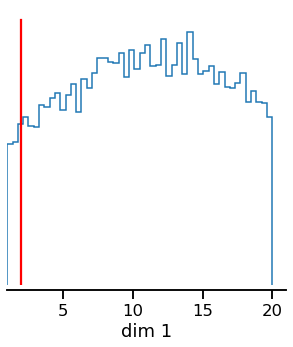

In [31]:
fig, axes = analysis.pairplot(samples[0],
                           limits=[[1,21], [1,21]],
                           #ticks=[[2,10], [2,10]],
                           figsize=(5,5),
                           points=true_index.round(),
                           points_offdiag={'markersize': 6},
                           points_colors='r');